# Tutorial 2: Why Deep Learning?

In the last lesson, we built some basic intuition around ML, and wrote a simple program using TensorFlow to classify Iris flowers. We did this using a multi-layer deep neural network that took a few features like sepal and petal dimensions as input, and produced probabilities for different classes.

While discussing possible methods to identify these flowers, we suggested that we could use sophisticated methods such as classifying flowers based on photographs. Such a method would only require access to the pixels of various Iris flower photographs to do classification (if such a data set were available), and wouldn't require us to build any specialized measurement features.

We'll cover image recognition methods in a future lesson, but that is one example of the power of deep learning methods: they often reduce the need for specialized feature engineering; instead, they allow inferences to be drawn based directly on raw input data.

In this lesson, we'll cover some of the intuition around why deep neural networks add value beyond simple methods like logistic regression.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np

%load_ext autoreload
%autoreload 1
%aimport tutorial.point_datasets
%aimport tutorial.tf_functions

In each following section, we're going to generate a sample of 2-dimensional points across two different classes/colors according to a probability distribution, and train a model to learn how to distinguish the two points.

Let's define a function that takes in a data set and an TensorFlow estimator, along with additional parameters, and splits the data set into train and test subsets, trains a classifier on the train subset, and evaluates it on the test subset, printing the result.

In [2]:
def train_and_evaluate(data, classifier, batch_size=10, steps=100):
    train_data = data.sample(frac=0.8, random_state=200) # 80% of examples for the training set
    test_data = data.drop(train_data.index).sample(frac=1, random_state=200)
    train_x, train_y = train_data.drop('y', axis=1), train_data['y']
    test_x, test_y = test_data.drop('y', axis=1), test_data['y']
    
    classifier.train(
        input_fn=lambda:tutorial.tf_functions.train_input_fn(train_x, train_y, batch_size=batch_size),
        steps=steps)
    eval_result = classifier.evaluate(
        input_fn=lambda:tutorial.tf_functions.eval_input_fn(test_x, test_y, batch_size=batch_size))
    for key,value in sorted(eval_result.items()):
        print('%s: %0.2f' % (key, value))
    return classifier

## Logistic Regression

Recall that a logistic regression model generates a probability between 0 and 1, which is the probability that the output belongs to the "positive" class. It's one of the simplest ML models we can build for classification problems, and we'll use that to establish a baseline model that works on simple classification problems but does not do so well on more complex problems.

For the first example, we're going to pick a data set that's trivial to learn using logistic regression. We will use a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) to generate two clusters of points corresponding to two distinct classes. We will generate them in a way that there is ample space between the two clusters. Here's what we mean:

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


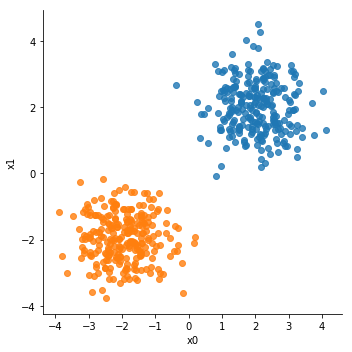

In [3]:
gaussian = tutorial.point_datasets.gaussian()
tutorial.point_datasets.plot_dataset(gaussian)

Let's now generate training and test subsets from this data, and train a logistic regression model on the data.

Recall that we generate a *feature column* for each feature we want to use as input to the model. In this case, we'll simply use the `x0` and `x1` coordinates of the points as features.

In [4]:
gaussian_feature_columns = [
    tf.feature_column.numeric_column('x0'),
    tf.feature_column.numeric_column('x1')
]

And then we can define a logistic regression estimator in TensorFlow and train a model.

In [5]:
gaussian_model = tf.estimator.LinearClassifier( 
    feature_columns=gaussian_feature_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.03))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpio3neip1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1286baba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Let's now train and evaluate the model on our data.

In [6]:
train_and_evaluate(gaussian, gaussian_model, batch_size=10, steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpio3neip1/model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:Saving checkpoints for 100 into /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpio3neip1/model.ckpt.
INFO:tensorflow:Loss for final step: 1.8847163.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17-05:46:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpio3neip1/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-05:46:46
INFO

We got an accuracy of 1.0, i.e. 100% of our test samples were classified correctly! How come?

The answer is that the data set is almost too perfect for a logistic regression model: it is perfectly [linearly separable](https://en.wikipedia.org/wiki/Linear_separability). In other words, it is possible to draw a line through the data such that all points belonging to one class fall on one side of the line, while points belonging to the other class fall on the other. Logistic regression, which is part of a set of classifiers known as [linear classifiers](https://en.wikipedia.org/wiki/Linear_classifier), relies on this linear separability assumption in order to perform well.

## XOR dataset

Let's work with a slightly more complex data set, the [XOR](https://en.wikipedia.org/wiki/Exclusive_or) data set.

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


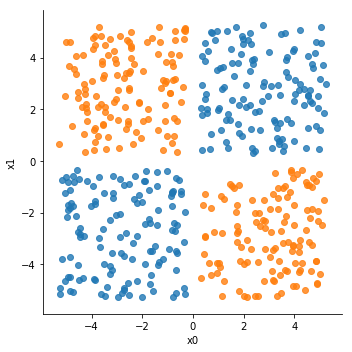

In [7]:
xor = tutorial.point_datasets.xor()
tutorial.point_datasets.plot_dataset(xor)

This data set is generated according to an XOR function; specifically, if both `x0` and `x1` are positive or negative, then the point belongs to the `0` class, while if only one of `x0` and `x1` is positive, then the point belongs to the `1` class. This is a classic example of a non-linearly separable data set -- it is impossible to draw a single line anywhere through the points that allows clean separation of points belonging to one class.

What happens if we train a logistic regression model using `x0` and `x1` as features?

In [8]:
xor_feature_columns_1 = [
    tf.feature_column.numeric_column('x0'),
    tf.feature_column.numeric_column('x1')
]

xor_model_1 = tf.estimator.LinearClassifier( 
    feature_columns=xor_feature_columns_1,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.03))

train_and_evaluate(xor, xor_model_1, batch_size=10, steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpy2x4dzf2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1286bfeb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

We get an accuracy of < 50%! This is just about as bad as random -- if we were to flip a coin for each example in the data set and use that to make predictions, we'd probably get a similar accuracy.

### The value of feature engineering

In the previous lesson, we talked briefly about the value of picking good features for ML models, and the negative effect on model performance when we don't pick informative enough features. It is usually possible to design better features through domain expertise on the problem. Not only does this include finding new properties of the data, but also includes *transforms* on the data that represent combinations of features.

We can easily generate new features for our data and save them as new columns in our data frame:

```
xor['x0_plus_x1'] = xor['x0'] + xor['x1']
```

Let's try to design a transformed feature that captures information from `x0` and `x1` *together*, since that is the basis for the definition of the XOR labels (if `x0` and `x1` are both either positive or both negative, then the point belongs to one class; if only one of `x0` and `x1` is positive, then the points belong to the other class). *Hint: the product of two positive or two negative numbers is positive, while the product of one positive and one negative number is negative*.

In [9]:
# Uncomment the following line and complete the statement
xor['x0_times_x1'] = xor['x0'] * xor['x1']

In [10]:
xor_feature_columns_2 = [
    tf.feature_column.numeric_column('x0'),
    tf.feature_column.numeric_column('x1'),
    # Uncomment next line
    tf.feature_column.numeric_column('x0_times_x1')
]

xor_model_2 = tf.estimator.LinearClassifier( 
    feature_columns=xor_feature_columns_2,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.03))

train_and_evaluate(xor, xor_model_2, batch_size=10, steps=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpe1fjf1ez', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10e337240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

This time, we got an accuracy of 100%, just by adding an additional feature! Interestingly, you'll discover that in this particular instance, the new feature is the *only* feature you need for the model to train effectively (i.e. you can remove the `x0` and `x1` feature columns and still train a model that gives 100% accuracy).

### Deep learning: less feature engineering, more ML

We saw that by adding a simple "cross" feature to the model, we were able to train a logistic regression model on the data effectively. But what if could get similar performance without additional feature engineering?

#### Detour: TensorFlow Playground

Let's take a brief detour to play with the TensorFlow Playground, which is an online tool that allows visualization of neural network training and evaluation on small data sets.

> Click [here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.47248&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&percTrainData_hide=false&noise_hide=true&problem_hide=true&regularizationRate_hide=true&regularization_hide=true&discretize_hide=true) to access TensorFlow Playground

#### Why is it called deep learning?

As we saw from playing around with TensorFlow Playground, we can actually learn a solution to the XOR data set *without* designing additional features, simply by creating a deep neural network. This is a powerful tool for more complex data sets like images, where instead of designing complex features based on the images (traditionally requiring background in signal processing), we can use the pixels of the images as inputs to complex neural network models like [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network).

That is the basis for why these methods are called *deep* -- it's because they learn deeper representations from the data instead of having to be explicitly shown those representations.

Just as an illustration, let's recreate what we did in TensorFlow playground on the same XOR data set, and use a deep neural network to train a classification model for this data.

In [11]:
xor_feature_columns_3 = [
    tf.feature_column.numeric_column('x0'),
    tf.feature_column.numeric_column('x1')
]

xor_model_3 = tf.estimator.DNNClassifier( 
    feature_columns=xor_feature_columns_3,
    hidden_units=[8, 8, 8], # these are the hidden layers
    optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.03))

train_and_evaluate(xor, xor_model_3, batch_size=10, steps=150)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpds1zmh37', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12a8eb8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

## Circle dataset: feature engineering is hard, deep learning easier

The XOR example showed how deep learning can be useful (it is no longer necessary to define specific features). However, in that case, the problem was also trivially solved by adding a cross feature. The "circle" data set, where the two classes of points form concentric circles, is harder to get right using feature engineering (even though it's possible).

For this data set, let's use TensorFlow Playground exclusively in order to build an effective ML model. The playground for the circle data set can be found [here](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.63050&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&percTrainData_hide=false&noise_hide=true&problem_hide=true&regularizationRate_hide=true&regularization_hide=true&discretize_hide=true).

## Spiral dataset: a bit of both!

The spiral data set is the most challenging data set to train a classification model on.

/usr/local/miniconda3/envs/ml_tutorials/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


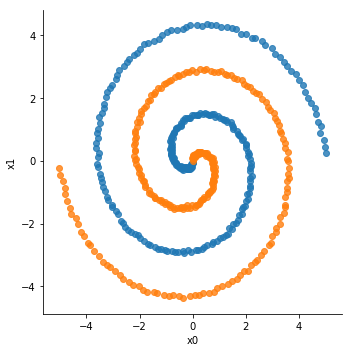

In [12]:
spiral = tutorial.point_datasets.spiral()
tutorial.point_datasets.plot_dataset(spiral)

Let's first attempt to do this in the [TensorFlow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.63050&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&percTrainData_hide=false&noise_hide=true&problem_hide=true&regularizationRate_hide=true&regularization_hide=true&discretize_hide=true), and then attempt to solve it using code.

Hints:

1. We might need to do both feature engineering and add multiple layers in order to fit this distribution
2. For feature engineering, we should utilize the knowledge that the $\sin{x}$ function (`np.sin(x)`) is used to generate the spiral distribution in the first place.
3. We may have to play with the `steps` parameter, which is the number of times the training process will pass over the data set before stopping.

In [13]:
## Step 1 [CHANGE THIS]: add more features (if any)
spiral['sin_x0'] = np.sin(spiral['x0'])
spiral['sin_x1'] = np.sin(spiral['x1'])

# Step 2 [CHANGE THIS]: define feature columns using above features
spiral_feature_columns = [
    tf.feature_column.numeric_column('x0'),
    tf.feature_column.numeric_column('x1'),
    tf.feature_column.numeric_column('sin_x0'),
    tf.feature_column.numeric_column('sin_x1'),
]

# Step 3 [CHANGE THIS]: define hidden layers and number of units per layer
spiral_hidden_units = [8, 7, 6]

# Step 4 [Optional]: change number of steps (probably need much higher than in Playground)
spiral_steps = 800

spiral_model = tf.estimator.DNNClassifier( 
    feature_columns=spiral_feature_columns,
    hidden_units=spiral_hidden_units,
    activation_fn=tf.nn.tanh,
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.03))

train_and_evaluate(spiral, spiral_model, batch_size=10, steps=spiral_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/rd/b17613hs1db4s7g4hsp7y9bm0000gn/T/tmpv00yxy63', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x10e2f1780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

## Conclusion

Hopefully, we've seen the power of deep neural networks in inferring certain representations within the input data automatically.

In general, practitioners tend to use a combination of domain-specific feature engineering and multi-layer deep neural networks in order to build models.

The type of neural networks we've been working with so far are called [multi-layer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron). There are more complicated neural network structures, such as Convolutional Neural Networks for image classification, LSTMs for text models, and many more. We'll cover some of these in subsequent tutorials.